In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot  as plt
import sys
import logging
from PIL import Image
import imagesize
import tensorflow as tf
import tensorflow_hub as hub
import pathlib
import numpy as np
import os
import gc
import glob
import random
import shutil
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import random
import pandas as pd
import zipfile
import datetime
import keras
from keras import backend as K
from imageio import imwrite
from itertools import product
from tqdm.notebook import tqdm, trange
!pip install -U tensorflow-addons

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    InputSpec,
    DepthwiseConv2D,
    Conv2D,
    Conv2DTranspose,
    Reshape,
    Dropout,
    BatchNormalization,
    Add,
    ReLU,
    LeakyReLU,
    ZeroPadding2D,
    Dense, Flatten, MaxPool2D, Activation
)

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D

from random import choice

import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
tf.random.set_seed(42)
%load_ext tensorboard
print(tf.version.VERSION)

tf.config.run_functions_eagerly(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.4 MB/s 
2.8.2


In [3]:
!unzip -d /content/data /content/drive/MyDrive/Datasets/Gans/AnimeFace/low_res_anime_face.zip 

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/images/62764_2019.jpg  
  inflating: /content/data/images/62765_2019.jpg  
  inflating: /content/data/images/62766_2019.jpg  
  inflating: /content/data/images/62767_2019.jpg  
  inflating: /content/data/images/62768_2019.jpg  
  inflating: /content/data/images/62769_2019.jpg  
  inflating: /content/data/images/6276_2003.jpg  
  inflating: /content/data/images/62770_2019.jpg  
  inflating: /content/data/images/62771_2019.jpg  
  inflating: /content/data/images/62772_2019.jpg  
  inflating: /content/data/images/62773_2019.jpg  
  inflating: /content/data/images/62774_2019.jpg  
  inflating: /content/data/images/62775_2019.jpg  
  inflating: /content/data/images/62776_2019.jpg  
  inflating: /content/data/images/62777_2019.jpg  
  inflating: /content/data/images/62778_2019.jpg  
  inflating: /content/data/images/62779_2019.jpg  
  inflating: /content/data/images/6277_2003.jpg  
  inflating: /content/data/images

In [4]:
DATA_DIR = "/content/data/images/"
data_dir= pathlib.Path(DATA_DIR)

In [5]:
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

63565


In [6]:
anime = list(data_dir.glob('*.jpg'))
Image.open(str(anime[random.randint(0,image_count)])).size

(56, 56)

In [7]:
# # Get the Image Resolutions
# import imagesize
imgs = [img.name for img in (data_dir).iterdir() if img.suffix == ".jpg"]
# img_meta = {}
# for f in imgs: img_meta[str(f)] = imagesize.get(str(data_dir)+"/"+f)

# # Convert it to Dataframe and compute aspect ratio
# img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
# img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
# img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

# print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
# img_meta_df.head()

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)
# points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
# ax.set_title("Image Resolution")
# ax.set_xlabel("Width", size=14)
# ax.set_ylabel("Height", size=14)

#Input pipeline

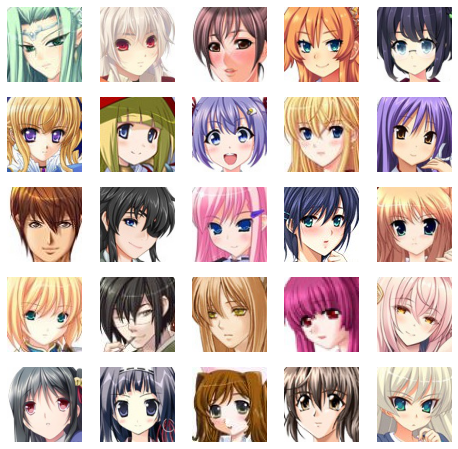

In [8]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        image = plt.imread(str("/content/data/images/"+imgs[5*i+j]))
        ax[i,j].imshow(image)
        ax[i,j].axis('off')

In [9]:
# os.makedirs("/content/drive/MyDrive/Models/AnimeFace/checkpoints")
# os.makedirs("/content/drive/MyDrive/Models/AnimeFace/model")
# os.makedirs("/content/drive/MyDrive/Models/AnimeFace/results")
CKPT_DIR = "/content/drive/MyDrive/Models/AnimeFace/checkpoints"
MODEL_DIR = "/content/drive/MyDrive/Models/AnimeFace/model"
RESULT_DIR = "/content/drive/MyDrive/Models/AnimeFace/results"

In [10]:
# /content/drive/MyDrive/Models/AnimeFace

BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 64
IMG_HEIGHT = 64

def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image


# Normalizing the images to [-1, 1]
def normalize(input_image):
    input_image = (input_image / 127.5) - 1
    return input_image

def load_image_train(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    print(image)
    image = resize(image, IMG_HEIGHT, IMG_WIDTH)
    image = normalize(image)
    return image

In [11]:
train_dataset = tf.data.Dataset.list_files(str(pathlib.Path(DATA_DIR+"/*.jpg")))
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Tensor("Cast:0", shape=(None, None, None), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [12]:
def Generator(latent_dim):
    
    n_nodes = 512 * 4 * 4
    
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', activation="tanh"))
    return model

In [13]:
Generator(100).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        4194816   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      2097408   
 ranspose)                                              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


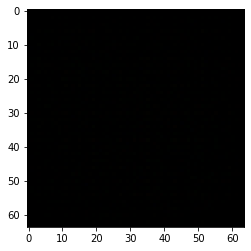

In [14]:
generator = Generator(100)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])

In [15]:
def Discriminator(in_shape=(64, 64, 3)):
    
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2D(1024, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Conv2D(2045, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.002, beta_1=0.5)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [16]:
Discriminator().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 512)        

In [17]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000092]], shape=(1, 1), dtype=float32)


In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
checkpoint_dir = CKPT_DIR
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager  = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=2)

In [23]:
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [24]:
print(ckpt_manager.checkpoints)

['/content/drive/MyDrive/Models/AnimeFace/checkpoints/ckpt-51', '/content/drive/MyDrive/Models/AnimeFace/checkpoints/ckpt-52']


In [25]:
# !rm -rf /content/drive/MyDrive/Models/AnimeFace/results/*
# !rm -rf /content/drive/MyDrive/Models/AnimeFace/checkpoints/*

In [26]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 9

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
def generate_and_save_images(model, epoch, test_input):

    noise = tf.random.normal([num_examples_to_generate, noise_dim])

    predictions = model(test_input, training=False)
    predictions = 0.5 * predictions + 0.5
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig(RESULT_DIR+'/image_at_epoch_z_{:04d}.png'.format(epoch))
    plt.show()

In [28]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [29]:
def train(dataset, epochs, ckpt_manager):
    if ckpt_manager.latest_checkpoint:
        print("Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    for epoch in range(epochs):

        for step, image_batch in tqdm(enumerate(dataset), total=1987):
            train_step(image_batch)

        generate_and_save_images(generator,
                                    epoch + 1,
                                    seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 1 == 0:
            ckpt_manager.save()

Restored from /content/drive/MyDrive/Models/AnimeFace/checkpoints/ckpt-52


  0%|          | 0/1987 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


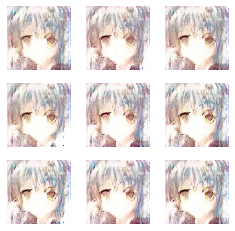

  0%|          | 0/1987 [00:00<?, ?it/s]

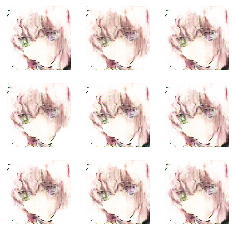

  0%|          | 0/1987 [00:00<?, ?it/s]

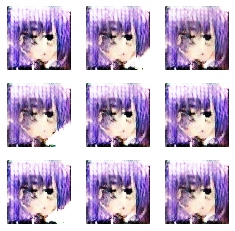

  0%|          | 0/1987 [00:00<?, ?it/s]

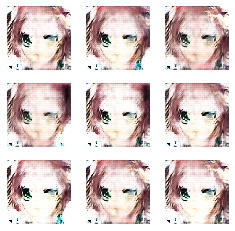

  0%|          | 0/1987 [00:00<?, ?it/s]

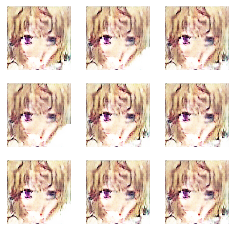

  0%|          | 0/1987 [00:00<?, ?it/s]

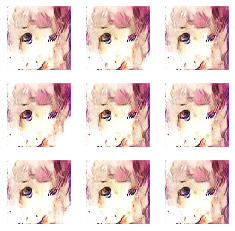

  0%|          | 0/1987 [00:00<?, ?it/s]

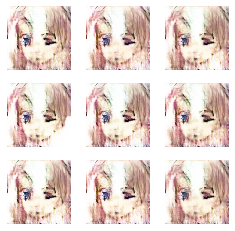

  0%|          | 0/1987 [00:00<?, ?it/s]

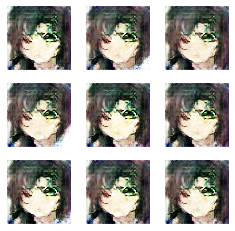

  0%|          | 0/1987 [00:00<?, ?it/s]

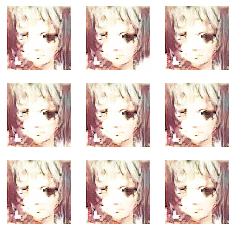

  0%|          | 0/1987 [00:00<?, ?it/s]

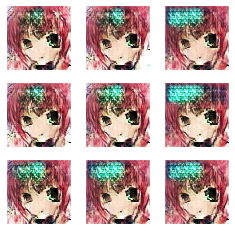

  0%|          | 0/1987 [00:00<?, ?it/s]

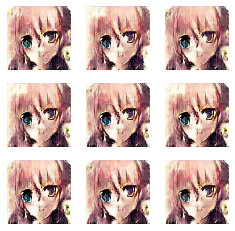

  0%|          | 0/1987 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [30]:
train(train_dataset, EPOCHS, ckpt_manager)

In [36]:
import imageio
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8714ozg8
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-8714ozg8
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=309cfb18c5f7b8107ffd01610864f6daf2148357af29c4241406f48eefe03e57
  Stored in directory: /tmp/pip-ephem-wheel-cache-d_y_u9rd/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [42]:
anim_file = 'animeGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Models/AnimeFace/results/*.png')
    print(filenames)
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

['/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0026.png', '/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0028.png', '/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0025.png', '/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0024.png', '/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0023.png', '/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0027.png', '/content/drive/MyDrive/Models/AnimeFace/results/Copy of image_at_epoch_0022.png', '/content/drive/MyDrive/Models/AnimeFace/results/image_at_epoch_0001.png', '/content/drive/MyDrive/Models/AnimeFace/results/image_at_epoch_0002.png', '/content/drive/MyDrive/Models/AnimeFace/results/image_at_epoch_0003.png', '/content/drive/MyDrive/Models/AnimeFace/results/image_at_epoch_0004.png', '/content/drive/MyDrive/Models/AnimeFace/results/image_at_epoch_0005.png', '/content/drive/MyDrive/Models/AnimeFace/re


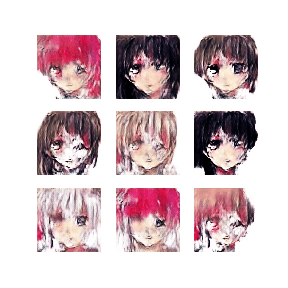

In [43]:
embed.embed_file(anim_file)